## Use case: Network traffic analysis for malware detection. 
The dataset contains features of network traffic such as timestamp, duration, protocol, number of packets, size of pakets and whether malware was contained in the flow or not. Analysis is expected the the row level, and two rows of data are independent of each other

_Dataset can be obtained here https://github.com/stratosphereips/ML-for-Network-Security_

## Import necessary libraries

In [64]:
import pandas as pd  # dataframe manipulations
import numpy as np # manipulate data as arrays
import time # datetime manipulations
import datetime # same ^*^
import warnings # supress warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #squash data column-wise between 0 and 1 and transform 
                                                              # categorical data
scaler = MinMaxScaler()
enc = OneHotEncoder(handle_unknown='ignore')
from sklearn.model_selection import train_test_split #split datasetinto training and test sets
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier #decision tree algos
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score #evaluation of accuracy and other metrics
import matplotlib.pyplot as plt #plotting library
import seaborn #also a great plotting lib
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #visualizing decision trees
import pydotplus #create graph of visualization
import graphviz #rendering of decision tree
import collections

## Import and manipulate data

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y/%m/%d %H:%M:%S.%f')

dfmal = pd.read_csv("C:\\Users\\apurnaik\\Desktop\\malware.binetflow.txt",sep = "\t", parse_dates=['StartTime'] , date_parser=dateparse)
dfnorm = pd.read_csv("C:\\Users\\apurnaik\\Desktop\\normal.binetflow.txt",sep = "\t", parse_dates=['StartTime'] , date_parser=dateparse)

In [3]:
print(dfnorm.shape)
print(dfmal.shape)

(4517, 16)
(53372, 16)


In [4]:
dfmal.dropna(subset = ['Label'], inplace = True)
dfnorm.dropna(subset = ['Label'], inplace = True)

print(dfnorm.shape)
print(dfmal.shape)

(4515, 16)
(53370, 16)


## Data exploration

### What is the mode of entry for malwares?

In [5]:
dfmal.Label.value_counts()

flow=Malware-UDP-DNS                   25657
flow=Background-UDP-Attempt-DNS        12969
flow=Malware-TCP                        8384
flow=Background-UDP-DNS                 6116
flow=Background-ICMP                     224
flow=Background-UDP-Attempt                9
flow=Background                            4
flow=Background-ARP                        3
flow=Background-UDP-Attempt-NetBIOS        3
flow=TCP-Established-To-Microsoft-7        1
Name: Label, dtype: int64

In [6]:
dfmal[:3]

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,SrcPkts,Label
1,1970-01-01 01:00:00.000000,0.000000,llc,00:00:00:00:00:00,0,->,00:00:00:00:00:00,0,INT,NaN,NaN,1,60,60,1,flow=Background
2,1970-01-01 01:00:08.140073,0.000000,udp,0.0.0.0,68,->,255.255.255.255,67,INT,0.0,NaN,1,344,344,1,flow=Background-UDP-Attempt
3,1970-01-01 01:00:08.140269,71.165138,udp,10.0.2.2,67,->,10.0.2.15,68,INT,16.0,NaN,3,1770,1770,3,flow=Background-UDP-Attempt


In [7]:
# merge the two datasets
dfmal['Threat'] = 1
dfnorm['Threat'] = 0
dfnorm.head(1)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,SrcPkts,Label,Threat
1,1970-01-01 01:00:00,0.0,llc,00:00:00:00:00:00,0,->,00:00:00:00:00:00,0,INT,NaN,NaN,1,60,60,1,flow=Background,0


In [8]:
dfall = pd.concat([dfmal, dfnorm], axis = 0)
dfall.dropna(subset = ['Label'], inplace = True)
dfall.shape

(57885, 17)

In [9]:
dfall['Label_v1'] = dfall['Label'].apply(lambda x: x[12:] if x.startswith('flow=Normal') else (x[13:] if x.startswith('flow=Malware') else x.strip()[16:] if x.startswith('flow=Background') else x))
# dfall['Label_v1'].value_counts()

In [12]:
# mode of entry for malwares grouped by whether it is actually a malware or a benign 
dfall.groupby('Threat')['Label_v1'].value_counts().sort_values( ascending = False)

Threat  Label_v1                           
1       UDP-DNS                                31773
        UDP-Attempt-DNS                        12969
        TCP                                     8384
0       TCP-WEB-Established-TLS                 1630
        UDP-DNS                                 1096
        TCP-WEB-Established                      719
        Google-Net-8                             324
1       ICMP                                     224
0       UDP-Attempt-DNS                          154
        TCP-Facebook-Net-1                       153
        Google-Net-9                             147
        UDP-Attempt                              105
        Google-Net-6                              51
        ICMP                                      38
        UDP-Established                           32
        To-Microsoft-21                           18
        IGMP                                      13
        Google-Net-10                             13
1 

### convert date to timestamp

In [14]:
s = dfall.iloc[1286]['StartTime']
epoch = pd.datetime(1970, 1, 1,0,0,0,0)
diff = s-epoch
print (diff.total_seconds())

3767.739017


In [15]:
epoch = pd.datetime(1970,1,1)
dfall['StartTimeTimestamp'] = dfall['StartTime'].apply(lambda x: ((x-epoch).total_seconds())*100000)

### Direction of flow: convert from symbol to category

In [16]:
d = {'   ->':'forward','  <->':'both', '  who':'who'}
dfall['Direction'] = dfall['Dir'].map(d)

In [17]:
dfall['Direction'].value_counts()

both       31879
forward    26001
who            5
Name: Direction, dtype: int64

In [93]:
dfall[:4]

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,SrcPkts,Label,Threat,StartTimeTimestamp,Direction
1,1970-01-01 01:00:00.000000,0.000000,llc,00:00:00:00:00:00,0,->,00:00:00:00:00:00,0,INT,NaN,NaN,1,60,60,1,flow=Background,1,360000000.0,forward
2,1970-01-01 01:00:08.140073,0.000000,udp,0.0.0.0,68,->,255.255.255.255,67,INT,0.0,NaN,1,344,344,1,flow=Background-UDP-Attempt,1,360814007.3,forward
3,1970-01-01 01:00:08.140269,71.165138,udp,10.0.2.2,67,->,10.0.2.15,68,INT,16.0,NaN,3,1770,1770,3,flow=Background-UDP-Attempt,1,360814026.9,forward
4,1970-01-01 01:00:08.156845,3554.205811,arp,10.0.2.15,NaN,who,10.0.2.2,NaN,CON,NaN,NaN,22,924,462,11,flow=Background-ARP,1,360815684.5,who


In [299]:
dfall['SrcAddr'].isnull().sum()

0

### Keep only those cols with no missing values

In [51]:
for i in dfall.columns:
    if dfall[i].isnull().sum()==0:
        print(' "%s", ' %i)
#         print '%s %s %s'%('python','is','fun')

dfall_sub = dfall[[ "StartTime", 
 "Dur", 
 "Proto", 
 "SrcAddr", 
 "Dir", 
 "DstAddr", 
 "State", 
 "TotPkts", 
 "TotBytes", 
 "SrcBytes", 
 "SrcPkts", 
 "Label", 
 "Threat", 
 "StartTimeTimestamp", 
 "Direction",
 "Label_v1"]]

# for i in dfall_sub.columns:
#     print(i)
    
#     print(dfall_sub[i].value_counts())
#     print("\n")

 "StartTime", 
 "Dur", 
 "Proto", 
 "SrcAddr", 
 "Dir", 
 "DstAddr", 
 "State", 
 "TotPkts", 
 "TotBytes", 
 "SrcBytes", 
 "SrcPkts", 
 "Label", 
 "Threat", 
 "Label_v1", 
 "StartTimeTimestamp", 
 "Direction", 


In [282]:
dfall_sub[:2]

,StartTime,Dur,Proto,SrcAddr,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,SrcPkts,Label,Threat,StartTimeTimestamp,Direction,Label_v1
1,1970-01-01 01:00:00.000000,0.0,llc,00:00:00:00:00:00,->,00:00:00:00:00:00,INT,1,60,60,1,flow=Background,1,360000000.0,forward,
2,1970-01-01 01:00:08.140073,0.0,udp,0.0.0.0,->,255.255.255.255,INT,1,344,344,1,flow=Background-UDP-Attempt,1,360814007.3,forward,UDP-Attempt


In [19]:
dfall_sub.groupby('Direction')['Threat'].value_counts().sort_values(ascending = False)

Direction  Threat
both       1         30445
forward    1         22922
           0          3079
both       0          1434
who        1             3
           0             2
Name: Threat, dtype: int64

In [20]:
dfall_sub.groupby('Proto')['Threat'].value_counts().sort_values(ascending = False)

Proto      Threat
udp        1         44754
tcp        1          8385
           0          2757
udp        0          1696
icmp       1           224
           0            43
igmp       0            13
ipv6-icmp  1             3
           0             3
arp        1             3
           0             2
llc        1             1
           0             1
Name: Threat, dtype: int64

### replace blank values in a subset of data where label is 'flow=Background' to 'no_more_info'

In [21]:
dfall_sub[dfall_sub["Label_v1"]=='']
dfall_sub['Label_v1'] = dfall_sub['Label_v1'].apply(lambda x: 'background' if x=='' else x)

### retain feats that will be fed into the model

In [22]:
exclude_cols = ['StartTime','Label','Dir']
include_cols = [i for i in dfall_sub.columns if i not in exclude_cols]
dfall_mod = dfall_sub[include_cols]

### normalize numeric cols

In [23]:
num_cols = dfall_mod.select_dtypes(include=[np.number]).columns
for i in num_cols:
    dfall_mod[i] = scaler.fit_transform(dfall_mod[[i]])

C:\Users\apurnaik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\apurnaik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\apurnaik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\apurnaik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\apurnaik\AppData\Local\Continuum\anaconda3\lib\site

In [24]:
dfall_mod['TotBytes'].describe()

count    57885.000000
mean         0.000059
std          0.004485
min          0.000000
25%          0.000002
50%          0.000002
75%          0.000003
max          1.000000
Name: TotBytes, dtype: float64

### One-hot-encode categorical cols

In [25]:
cat_cols = [i for i in dfall_mod if i not in num_cols]
print(cat_cols)
for i in cat_cols:
    df = pd.get_dummies(dfall_mod[[i]])
    dfall_mod = pd.concat([dfall_mod, df], axis = 1)
    dfall_mod.drop([i], inplace = True, axis = 1)
dfall_mod[:2]

['Proto', 'SrcAddr', 'DstAddr', 'State', 'Direction', 'Label_v1']


,Dur,TotPkts,TotBytes,SrcBytes,SrcPkts,Threat,StartTimeTimestamp,Proto_arp,Proto_icmp,Proto_igmp,...,Label_v1_To-Microsoft-3,Label_v1_To-Microsoft-30,Label_v1_To-Microsoft-7,Label_v1_UDP-Attempt,Label_v1_UDP-Attempt-DNS,Label_v1_UDP-Attempt-NetBIOS,Label_v1_UDP-DNS,Label_v1_UDP-Established,Label_v1_background,Label_v1_flow=TCP-Established-To-Microsoft-7
1,0.0,0.0,6.567139e-08,0.000002,0.0,1.0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,3.174117e-06,0.000097,0.0,1.0,0.001106,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## test train split

In [26]:
need_cols = [i for i in dfall_mod.columns if i != 'Threat']
X = dfall_mod[need_cols]
y = dfall_mod[['Threat']]
X[:3]

,Dur,TotPkts,TotBytes,SrcBytes,SrcPkts,StartTimeTimestamp,Proto_arp,Proto_icmp,Proto_igmp,Proto_ipv6-icmp,...,Label_v1_To-Microsoft-3,Label_v1_To-Microsoft-30,Label_v1_To-Microsoft-7,Label_v1_UDP-Attempt,Label_v1_UDP-Attempt-DNS,Label_v1_UDP-Attempt-NetBIOS,Label_v1_UDP-DNS,Label_v1_UDP-Established,Label_v1_background,Label_v1_flow=TCP-Established-To-Microsoft-7
1,0.000000,0.000000,6.567139e-08,0.000002,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.000000,0.000000,3.174117e-06,0.000097,0.000000,0.001106,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.019769,0.000013,1.878202e-05,0.000572,0.000045,0.001106,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(34731, 580)
(34731, 1)
(23154, 580)
(23154, 1)


# train

In [47]:
X_train, y_train = np.array(X_train), np.array(y_train)
y_train = [i for j in y_train for i in j]
X_test, y_test = np.array(X_test),np.array(y_test)
y_test = [i for j in y_test for i in j]

In [48]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Evaluate: standalone and K-fold cross validation

In [52]:
y_pred = clf.predict(X_test)
print(np.bincount(y_pred.astype(int)))

print('Confusion Matrix: \n',confusion_matrix(y_test, y_pred))
print('Accuracy of Classifier: \n',accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[ 1790 21364]
Confusion Matrix: 
 [[ 1782     3]
 [    8 21361]]
Accuracy of Classifier: 
 0.9995249201001987
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1785
         1.0       1.00      1.00      1.00     21369

   micro avg       1.00      1.00      1.00     23154
   macro avg       1.00      1.00      1.00     23154
weighted avg       1.00      1.00      1.00     23154



## Accuracy of the classifier: 99.95%

In [53]:
# 5 fold cross validation to reduce the possibility of getting high accuracy because of random chance, bias etc.
from sklearn.model_selection import cross_val_score

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores 

array([0.99971211, 0.99985603, 0.9995681 , 0.99899223, 0.9995681 ])

# Analyze and Interpret results

## Feature Importance
The features that were most important for getting the accuracy

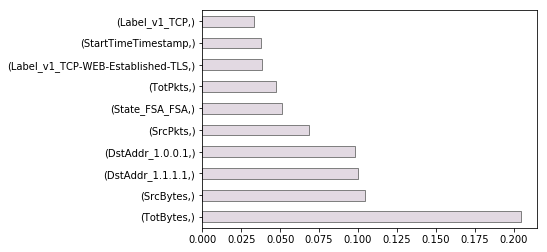

In [55]:
dffeat = pd.DataFrame(clf.feature_importances_, index = [X.columns], columns = ['Feature_Importance']).sort_values(by = ['Feature_Importance'], ascending = False)
dffeat = dffeat[dffeat['Feature_Importance'] > 0.005]

dffeat['Feature_Importance'][:10].plot(kind = "barh", colormap  = 'twilight', edgecolor = 'grey')

## Distribution of features total_packets and total_bytes, colored by whether malware network flow or not

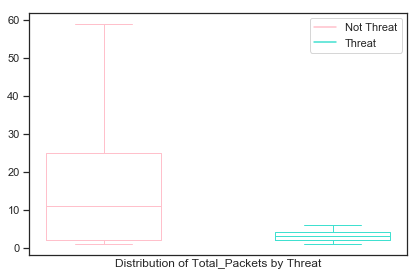

In [234]:
th_0 = list(dfall['TotPkts'][dfall['Threat']==0])
data_a = [[i for i in th_0]]

th_1 = list(dfall['TotPkts'][dfall['Threat']==1])
data_b = [[i for i in th_1]]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()
bp0 = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.1 , widths=0.1,sym = '', manage_xticks = False)
bp1 = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.1, widths=0.1, sym='', manage_xticks = False)
set_box_color(bp0, 'pink') # colors are from http://colorbrewer2.org/
set_box_color(bp1, 'turquoise')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='pink', label='Not Threat')
plt.plot([], c='turquoise', label='Threat')
plt.legend()

plt.xticks([])
plt.xlabel('Distribution of Total_Packets by Threat')
plt.tight_layout()

This may have been a very important feature from the model's point of view, however it might not make much sense in reality, as this is a case of causation, rather than correlation. My reasoning is, the data pertaining to a threat negative instance can encode a variety of situations, from network performance, lags etc, unlike threat positive instances that describe a very specific case.

## Distribution of features total_packets and total_source_bytes, colored by whether malware network flow or not

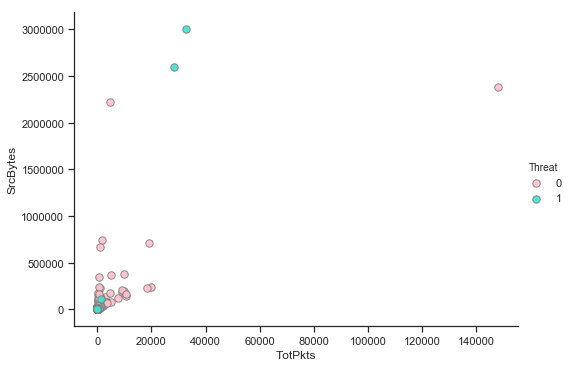

In [72]:
# dfall_mod['ref'] = 0
seaborn.set(style='ticks')
flatui = ['pink','turquoise']
# sns.palplot(sns.color_palette(flatui))
_threatvals= [0,1]
fg = seaborn.FacetGrid(data=dfall, hue='Threat', palette = flatui, hue_order=_threatvals, height=5.27, aspect=11.7/8.27)
fg.map(plt.scatter, 'TotPkts', 'SrcBytes',alpha = 0.9, edgecolor="grey", s = 55 ).add_legend()

As already illustrated, the data distribution for threat positive instances is much more compact

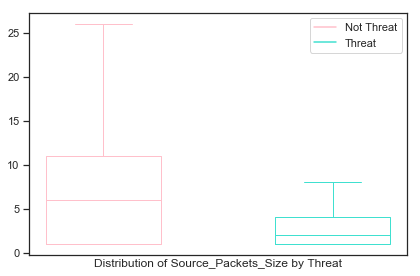

In [406]:
th_0 = list(dfall['SrcPkts'][dfall['Threat']==0])
data_a = [[i for i in th_0]]

th_1 = list(dfall['SrcPkts'][dfall['Threat']==1])
data_b = [[i for i in th_1]]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()
green_diamond = dict(markerfacecolor='g', marker='D')
bp0 = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.1 , widths=0.1,sym = '', manage_xticks = False, flierprops=green_diamond)
bp1 = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.1, widths=0.1, sym='', manage_xticks = False, flierprops=green_diamond)
set_box_color(bp0, 'pink') # colors are from http://colorbrewer2.org/
set_box_color(bp1, 'turquoise')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='pink', label='Not Threat')
plt.plot([], c='turquoise', label='Threat')
plt.legend()

plt.xticks([])
plt.xlabel('Distribution of Source_Packets_Size by Threat')
plt.tight_layout()

Remove these causal features from the model and see if we get the same accuracy

## Visualize Decision Tree
This visualization is just to provide intuition as to how the classifier might be analyzing the data and coming to the above conclusion. _Not to be taken literally_

In [56]:
# set system path for graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

In [377]:
# take the 20 most important features for visualization purpose to reduce complexity of the tree

X_tree = X[[i for j in dffeat[:20].index.to_list() for i in j]]
print(X_tree.shape)
X_tree.head()

(57885, 20)


,TotBytes,SrcBytes,DstAddr_1.1.1.1,DstAddr_1.0.0.1,SrcPkts,State_FSA_FSA,TotPkts,Label_v1_TCP-WEB-Established-TLS,StartTimeTimestamp,Label_v1_TCP,DstAddr_8.8.8.8,Label_v1_UDP-DNS,Proto_udp,DstAddr_8.8.4.4,Label_v1_UDP-Attempt-DNS,Dur,State_FSRPA_SPA,Label_v1_TCP-WEB-Established,Proto_tcp,Label_v1_Google-Net-8
1,6.567139e-08,0.000002,0,0,0.000000,0,0.000000,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0
2,3.174117e-06,0.000097,0,0,0.000000,0,0.000000,0,0.001106,0,0,0,1,0,0,0.000000,0,0,0,0
3,1.878202e-05,0.000572,0,0,0.000045,0,0.000013,0,0.001106,0,0,0,1,0,0,0.019769,0,0,0,0
4,9.522351e-06,0.000136,0,0,0.000227,0,0.000142,0,0.001109,0,0,0,0,0,0,0.987300,0,0,0,0
5,1.014623e-04,0.003089,0,0,0.001408,0,0.000418,0,0.001109,0,0,0,1,0,0,0.971178,0,0,0,0


### Test the accuracy using only the top 20 features

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X_tree, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(52096, 18)
(52096, 1)
(5789, 18)
(5789, 1)


In [384]:
dtree = DecisionTreeClassifier(criterion='gini',
    max_depth = 3,
    min_samples_split=4,
    min_samples_leaf=10)
dtree = dtree.fit(X,y)

In [350]:
y_pred = dtree.predict(X_test)

print('Confusion Matrix: \n',confusion_matrix(y_test, y_pred))
print('Accuracy of Classifier: \n',accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Confusion Matrix: 
 [[ 324  103]
 [   3 5359]]
Accuracy of Classifier: 
 0.9816894109518052
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86       427
         1.0       0.98      1.00      0.99      5362

   micro avg       0.98      0.98      0.98      5789
   macro avg       0.99      0.88      0.92      5789
weighted avg       0.98      0.98      0.98      5789



the top 10 features contribute to 99.9% accuracy of the model, meaning that rest of the features are obselete

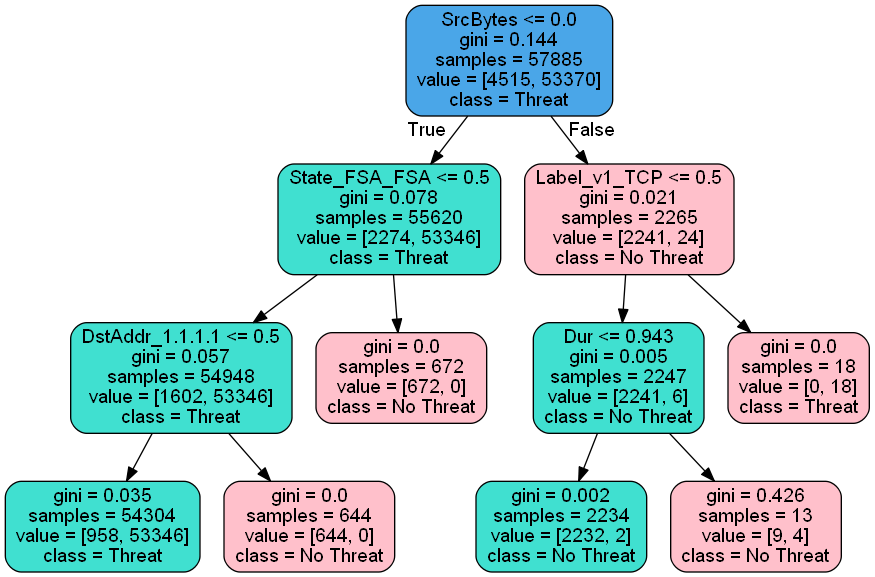

In [385]:
# Create DOT data
dot_data = tree.export_graphviz(dtree, out_file = None, 
                                feature_names = X.columns,
                                class_names = ['No Threat','Threat'], # model.classes_,
                                filled=True,
                                rounded=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
colors = ('turquoise', 'pink')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree1.png')

from IPython.display import Image
Image(filename='tree1.png', width=500,
    height=1000) 

* The tree is 3 layer deep excluding the root node, this is because 'max_depth' was specified as 3 to reduce the tree complexity. 
* The model chooses the 'Source Bytes' feature, which is the most 'impure' node (gini score is the highest.. the lower it is, the better). 
* It then splits the data into 1s and 0s (Threats and Non threats)
* The model iteratively tries to lower the gini index by splitting the nodes further until it reaches the max_depth of 3.

In [573]:
# if out_file is not None, 
# with open("tree_nonlimited.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

# Conclusion

Network flow attributes especially pertaning to amount of data sent and recieved are some of the most important factors. IP of the source and destination is important for threat negative cases.